You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os
if not os.path.isdir('k'):
 !git clone -b development15 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
!cd k && pip install .

Already up to date.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.6-py3-none-any.whl size=58747 sha256=ff07d9fef09680f83e6196ade020b829797fd117ae3f9f2d87136c73f4fe42b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-403q6put/wheels/c1/8a/57/56dbba25eff58e52e5365435c4fa102ad8d6f9787d3b4db13a
Successfully built cai
  Attempting uninstall: cai
    Found existing installation: cai 0.1.6
    Uninstalling cai-0.1.6:
      Successfully uninstalled cai-0.1.6


In [2]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
from tensorflow import keras
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.767017984 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Sat Jan 29 15:44:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

# Create folder structure with CIFAR-10 as png files.

In [6]:
verbose=True
root_folder = 'cifar10-as-png'
data_dir = root_folder + '/train';
test_dir = root_folder + '/test';

if not os.path.isdir(root_folder):
  os.mkdir(root_folder)
  x_train, y_train, x_test, y_test = cai.datasets.load_dataset(tf.keras.datasets.cifar10, verbose=verbose, lab=False, bipolar=False)
  cai.datasets.save_dataset_as_png(cai.datasets.fix_bad_tfkeras_channel_order(x_train)*255, y_train, dest_folder_name=data_dir)
  cai.datasets.save_dataset_as_png(cai.datasets.fix_bad_tfkeras_channel_order(x_test)*255, y_test, dest_folder_name=test_dir)

In [7]:
num_classes = 10
batch_size = 64
epochs = 180
target_size_x = 224
target_size_y = 224
seed = 12

In [8]:
train_datagen = cai.util.create_image_generator(validation_split=0.1, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0, rescale=1./255)
test_datagen = cai.util.create_image_generator_no_augmentation(rescale=1./255)
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler30(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 30
    result = base_learning
    if local_epoch < 7:
       result = base_learning * (1 + 0.5*local_epoch)
    else:
       result = (base_learning * 4) * ( 0.85**(local_epoch-7) )

    if result < 2.5245e-04:
      result = 2.5245e-04
    return result

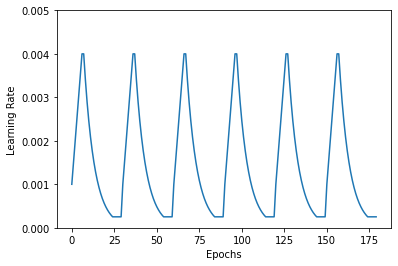

In [9]:
learning_rate_test = []
for epoch in range(epochs):
  learning_rate_test.append( cyclical_adv_lrscheduler30(epoch) )
plt.figure()
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.ylim([0.0000,0.005])
plt.plot(learning_rate_test)

In [10]:
def work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_loss'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [-1]:
      basefilename = '/content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.efficientnet.EfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes)
      else:
        model = cai.efficientnet.kEfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes,
          kType=kType)
        
      optimizer = keras.optimizers.RMSprop()
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model):
        model.summary(line_length=180)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit):
        train_flow = train_datagen.flow_from_directory(
            directory=data_dir,
            subset="training",
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        validation_flow = train_datagen.flow_from_directory(
            directory=data_dir,
            subset="validation",
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=False,
            seed=seed
        )
        history = model.fit(
          x = train_flow,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=validation_flow,
          callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler30)],
          workers=cpus_num,
          max_queue_size=128
          )
        plt.figure()
        plt.ylabel("Accuracy (training and validation)")
        plt.xlabel("Epochs")
        plt.ylim([0,1])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow_from_directory(
            directory=test_dir,
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=False,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        cai.datasets.test_flips_on_saved_model(x_test, y_test, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=True, center_crop=0.15)
      print('Finished: '+basefilename)

# Show Models

In [11]:
work_on_keffnet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1
Model: "efficientnet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 224, 224, 3)]                   0                    []                                                          
                                                                                                                                                                                    
 stem_conv_pad (ZeroPadding2D)                             (None, 225, 225, 3)                     0                    ['input_1[0][0]']                                           
   

# Fitting

Running: /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1
Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Epoch 1/180
704/704 [==============================] - ETA: 0s - loss: 2.0557 - accuracy: 0.3020
Epoch 00001: val_loss improved from inf to 1.73757, saving model to /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


704/704 [==============================] - 264s 350ms/step - loss: 2.0557 - accuracy: 0.3020 - val_loss: 1.7376 - val_accuracy: 0.3998 - lr: 0.0010
Epoch 2/180
704/704 [==============================] - ETA: 0s - loss: 1.4940 - accuracy: 0.4662
Epoch 00002: val_loss improved from 1.73757 to 1.43123, saving model to /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1-best_result.hdf5
704/704 [==============================] - 240s 338ms/step - loss: 1.4940 - accuracy: 0.4662 - val_loss: 1.4312 - val_accuracy: 0.4880 - lr: 0.0015
Epoch 3/180
704/704 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.5703
Epoch 00003: val_loss did not improve from 1.43123
704/704 [==============================] - 236s 334ms/step - loss: 1.2226 - accuracy: 0.5703 - val_loss: 1.5080 - val_accuracy: 0.5182 - lr: 0.0020
Epoch 4/180
704/704 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.6263
Epoch 00004: val_loss did not improve from 1.43123
704/704 [=======

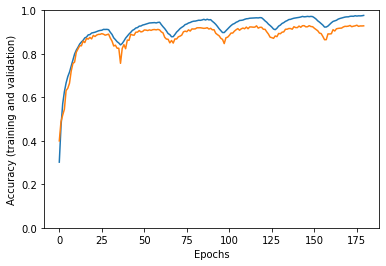

In [12]:
work_on_keffnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [13]:
work_on_keffnet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1
Found 10000 images belonging to 10 classes.
Best Model Results: /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1-best_result.hdf5
157/157 [==============================] - 10s 55ms/step - loss: 0.2286 - accuracy: 0.9486
loss 0.22858725488185883
acc 0.9485999941825867
Finished: /content/drive/MyDrive/output/JP30B31c-keffnet-CIFAR10--1
